In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/"


'Career Choice - 2026 Batch.pdf'
'Case study to examine linkages between environmental degradation -specifically soil pollution and population within India..gform'
'Colab Notebooks'
'Copy of Case study to examine linkages between environmental degradation -specifically soil pollution and population within India..gform'
'Decision Making.gslides'
'DE shaw resume.pdf'
'Emotion Detection Project'
'Fidelity Investment Resume.pdf'
'LMS Creds | Chennai | Citi I CitiBridge Program.xlsx'
'Meeting Reports'
'Resume_KK (1).pdf'
 Resume_KK.pdf
 Resume.pdf
'Screenshot 2023-12-22 214047.png'
 SSN-3122223002058-ECE-Kashika.pdf
 SSN-3122223002058-Kashika.pdf
'UHV Case Study.gsheet'


In [6]:
%cd "/content/drive/My Drive/Emotion Detection Project"


/content/drive/My Drive/Emotion Detection Project


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [8]:
## Load the datatset
df=pd.read_csv('combined_emotion.csv')

# Extract text and labels
texts = df["sentence"].values
labels = df["emotion"].values

# Encode labels into integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert labels to numerical values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 100      # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [9]:
from gensim.models import Word2Vec

# Load Gensim Word2Vec model
w2v_model = Word2Vec.load("word2vec_model.bin")

# Create an embedding matrix for Keras Embedding layer
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < max_words:  # Limit to max_words
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

# Now use this matrix in the embedding layer
embedding_layer = Embedding(input_dim=max_words,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)  # Set trainable=False to keep Word2Vec embeddings fixed


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding, LayerNormalization, LeakyReLU
from tensorflow.keras.models import Sequential

model = Sequential([
    embedding_layer,  # Using the pre-trained Word2Vec embeddings
    Bidirectional(LSTM(256, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(128)),
    Dense(64),
    LeakyReLU(),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [11]:
# TRAIN MODEL
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 337s 31ms/step - accuracy: 0.8710 - loss: 0.3232 - val_accuracy: 0.9372 - val_loss: 0.1024
Epoch 2/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 368s 30ms/step - accuracy: 0.9374 - loss: 0.1111 - val_accuracy: 0.9374 - val_loss: 0.1006
Epoch 3/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 322s 30ms/step - accuracy: 0.9383 - loss: 0.1050 - val_accuracy: 0.9387 - val_loss: 0.1000
Epoch 4/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 331s 31ms/step - accuracy: 0.9396 - loss: 0.1017 - val_accuracy: 0.9391 - val_loss: 0.1218
Epoch 5/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 331s 31ms/step - accuracy: 0.9401 - loss: 0.0989 - val_accuracy: 0.9396 - val_loss: 0.0981
Epoch 6/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 382s 31ms/step - accuracy: 0.9401 - loss: 0.0981 - val_accuracy: 0.9383 - val_loss: 0.0970
Epoch 7/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 331s 31ms/step - accuracy: 0.9397 - loss: 0.0979 - val_accuracy: 0.9397 - val_loss: 0.0994
Epoch 8/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 381s 31ms/s

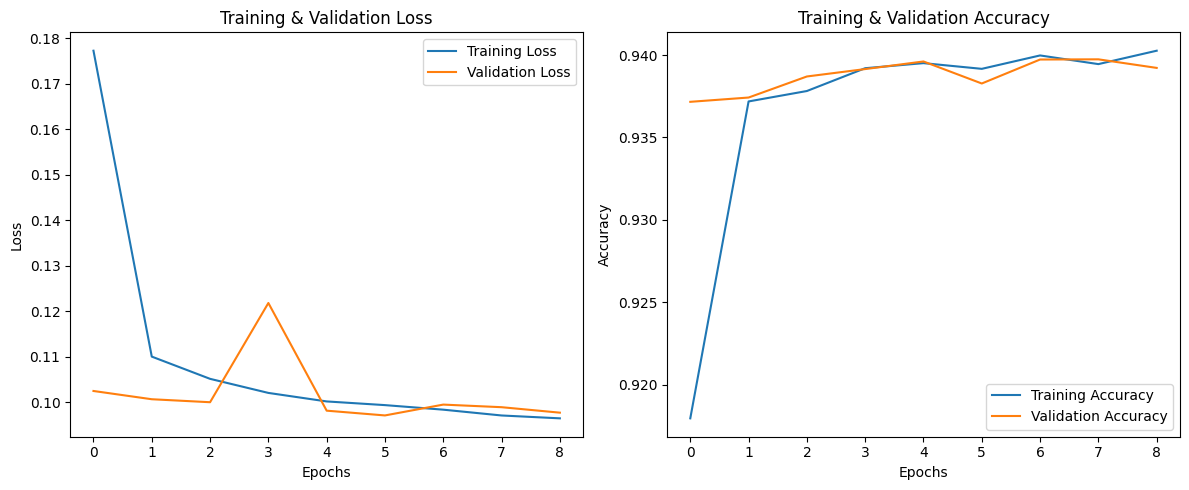

In [13]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history object
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy (if available)
if 'accuracy' in history_dict:  # Use 'acc' for older TensorFlow versions
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)

# Decode predicted labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)


2643/2643 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.9375 - loss: 0.0967
Test Accuracy: 0.9383
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step


In [14]:
def predict_emotion(sentence):
    # Load tokenizer and label encoder
    #with open("tokenizer.pkl", "rb") as file:
        #tokenizer = pickle.load(file)

    #with open("label_encoder.pkl", "rb") as file:
        #label_encoder = pickle.load(file)

    # Preprocess input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Load model
    #model = tf.keras.models.load_model("emotion_lstm_model.h5")

    # Make prediction
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction)
    predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_emotion




In [15]:
# Example usage
example_sentences =  [
        "The weather is wonderful today!",
        "I am feeling really sad and lonely.",
        "What an exciting game we had last night!",
        "I can't believe how much I've learned this year!",
        "I was so angry during the meeting today.",
        "I can't believe how everything turned out today, it's a bit overwhelming.",
        "I guess I'm doing okay, but it's not as good as I hoped.",
        "That was such a fantastic presentation, even though I made some mistakes.",
        "I'm so glad I made it through the day, but I'm exhausted!",
        "I can't stop thinking about how much better things could have been.",
        "It was a long day, but I had a lot of fun!",
        "My cat died today."
    ]

for i in example_sentences:
    print(i,":",predict_emotion(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
The weather is wonderful today! : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
I am feeling really sad and lonely. : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
What an exciting game we had last night! : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
I can't believe how much I've learned this year! : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
I was so angry during the meeting today. : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
I can't believe how everything turned out today, it's a bit overwhelming. : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
I guess I'm doing okay, but it's not as good as I hoped. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
That was such a fantastic presentation, even though I made some mistakes. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
I'm so glad I made it through the day, but I'm exhausted! : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
I can't stop thinking about how much better things could have been. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━

In [17]:
model.save('biLSTM.keras')

2643/2643 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step


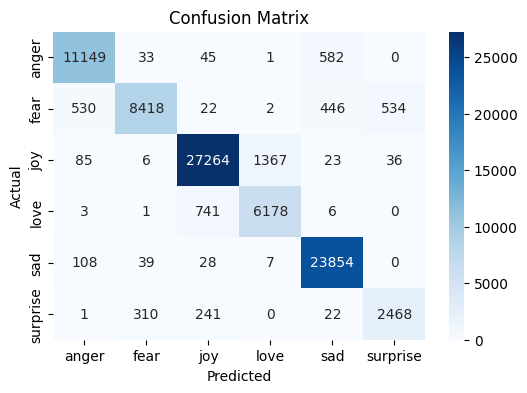

              precision    recall  f1-score   support

       anger       0.94      0.94      0.94     11810
        fear       0.96      0.85      0.90      9952
         joy       0.96      0.95      0.95     28781
        love       0.82      0.89      0.85      6929
         sad       0.96      0.99      0.97     24036
     suprise       0.81      0.81      0.81      3042

    accuracy                           0.94     84550
   macro avg       0.91      0.91      0.91     84550
weighted avg       0.94      0.94      0.94     84550



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

# Now compute the confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes))
emotion_labels = ['anger', 'fear', 'joy', 'love', 'sad', 'surprise']

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=emotion_labels,yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes)))
